##### Note 
Note that there is a python version that creates the csv files of this document, to save time 

In [1]:
import sys

sys.path.append('../../../common_code')
from PostProcessingScripts import * 
from formation_channels import * 
import astropy.stats

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

##########
# define colors for formation channels 
channelColorDict = {'classic':'#118AB2', 'stable B no CEE':'orange',  'immediate CE': '#EF476F'  , r'double-core CE':'#073B4C', 'other':'gray', 'vi':'cyan', 'vii':'#FFD166'}
List_formationchannelOptions = ['All',  'classic',  'stable B no CEE',  'immediate CE',  r'double-core CE', 'vi', 'vii', 'other']
ind_formationchannelOptions = [7,  1, 2, 3, 4, 5, 6, 0]
dictFormationChannelIndex =  {List_formationchannelOptions[i]: ind_formationchannelOptions[i] for i in range(len(List_formationchannelOptions))}

channelColorDict_lighter = {'classic':adjust_lightness(color='#118AB2', amount=1.6),'stable B no CEE':adjust_lightness(color='orange', amount=1.4), 'immediate CE':adjust_lightness(color='#EF476F', amount=1.2),\
                            r'double-core CE':adjust_lightness(color='#073B4C', amount=1.8), 'other':adjust_lightness(color='gray', amount=1.5),  'vi':adjust_lightness(color='cyan', amount=1.5), 'vii':adjust_lightness(color='#FFD166', amount=1.2)}
channelList = ['classic', 'stable B no CEE', 'vii',  'immediate CE',  r'double-core CE', 'other'] #, 'vi']
#######

import pandas as pd
from pathlib import Path

In [2]:
def obtain_redshiftsruns(pathData = '/Volumes/SimonsFoundation/DataDCO/'):
    BPSmodelName='B'
    DCOtype='BNS'
    path_ = '/Volumes/SimonsFoundation/DataDCO/' + alphabetDirDict[BPSmodelName] +'/'
    path  = path_ + 'COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'
    fdata = h5.File(path, 'r')
    redshifts = fdata['redshifts']['redshift'][...].squeeze()
    fdata.close()
    return redshifts 





adjustedChannelList = ['classic', 'stable B no CEE', 'vii', 'immediate CE',  r'double-core CE', 'other']
pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run 
print('available redshifts:', redshifts_runs) 

print(MSSFRnameslist)



available redshifts: [0.19230769 0.57692308 0.96153846 1.34615385 1.73076923 2.11538462
 2.5        2.88461538 3.26923077 3.65384615 4.03846154 4.42307692
 4.80769231 5.19230769 5.57692308 5.96153846 6.34615385 6.73076923
 7.11538462 7.5        7.88461538 8.26923077 8.65384615 9.03846154
 9.42307692 9.80769231]
['000', '111', '112', '113', '121', '122', '123', '131', '132', '133', '211', '212', '213', '221', '222', '223', '231', '232', '233', '311', '312', '313', '321', '322', '323', '331', '332', '333']


# code to create the csv files with the medians as a function of redshift:

runs for formation channel, or for total rate the medians. Might need to run again when I combine the vii channel with the only stable mass transfer channel

In [ ]:


def create_pd_redshift_from_xparam_for_fc(DCOtype='BHNS', BPSmodelName='A', pathData='/Volumes/SimonsFoundation/DataDCO/', quantile_values=[0.5, 0.25, 0.75],\
                                               weights_type='merger'):
    """
    whichplot='rate', 'ratio'
    
    """
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run    
    adjustedChannelList, DCOname = dict_channel_list[DCOtype], DCOname_dict[DCOtype]

    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'     # path for files 
    fdata = h5.File(full_data_path,'r')     # read in data 
    
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    
    xparams_to_run = ['mass_1_LVK', 'mass_2_LVK',  'mass_tot', 't_delay', 'mass_ratio_LVK', 'qZAMS', 'separationInitial', 'M1ZAMS', 'M2ZAMS']
    for xparam in xparams_to_run: 
        
        pd_file_path = './formation_median/'+ xparam + '_' + DCOtype + '_' + BPSmodelName + '_' + xparam + '_w_' + weights_type + '.csv'

        # make this a dictionary instead !!
        if xparam=='chirp_mass_LVK':
            param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        elif xparam=='mass_tot':
            param_x = massCO_LVKM1 + massCO_LVKM2
        elif xparam=='mass_ratio_LVK':
            param_x = MassRatioCO_LVK
        elif xparam=='mass_1_LVK':
            param_x = massCO_LVKM1
        elif xparam=='mass_2_LVK':
            param_x = massCO_LVKM2
        elif xparam=='log10_t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
            param_x = np.log10(param_x)
        elif xparam=='t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        elif xparam=='M1ZAMS':
            param_x = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        elif xparam=='M2ZAMS':
            param_x = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
        elif xparam=='qZAMS':
            param_x = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze() / fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        elif xparam=='separationInitial':
            param_x = fdata['doubleCompactObjects']['separationInitial'][...].squeeze()

    
        nZ = len(redshifts_runs)
        fc_data = np.zeros((nZ, 1)) # create empty dataset for redshifts 
        fc_data[:,0] = np.round(redshifts_runs,4)  # fill with redshift data rounded to 4 digits 
        df = pd.DataFrame(fc_data, columns=["redshift"])

    
        for nrC, Channel in enumerate(adjustedChannelList): 
            # obtain fc_mask for the requested channel name 
            ind_wanted = dictFormationChannelIndex[Channel]
            mask_MRR = (channels==ind_wanted)

            for ind_mssfr, mssfr in enumerate(MSSFRnameslist[1:]):

                median_at_redshifts = np.zeros_like(redshifts_runs)

                data_to_add = np.zeros((nZ, len(quantile_values)))
                data_to_add[:] = np.nan # start with nan values so that we do not plot datapoint if it doesnt exist 

                column_names = [Channel + 'xyz_' + mssfr+ ' q_' + str(quantile_values[i]) for i in range(len(quantile_values))] # creates array with header names 

                for z_ind, redshift in enumerate(redshifts_runs[:]):
                    redshift = np.round(redshift,4)

                    if weights_type=='merger':
                        fparam_key = 'weights_intrinsicPerRedshift'
                        weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
                    elif weights_type=='formation':
                        fparam_key = "weights_intrinsicFormationPerRedshift"
                        weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
                    weights_ = fdata[fparam_key][weightheader][...].squeeze()    
                    
                    
                    # we do not care about the very small rates, so do not report medians for formation channels at redshifts that dont pass the minimum channel contribution
                    if np.sum(weights_)>1E-4:  # and we dont want to calculate medians when the total rate is just super low 
                        fractional_contribution_fc = np.sum(weights_[mask_MRR])/np.sum(weights_) # contribution of the channel at this redshift 
                        if fractional_contribution_fc>=minimum_fractional_contribution_fc: 
                            data_to_add[z_ind] = weighted_quantile(values=param_x[mask_MRR], quantiles=quantile_values, sample_weight=weights_[mask_MRR])
#                     else:
#                         print('skipping channel', Channel, ' because fractional contribution is ', fractional_contribution_fc)

                        
                df_to_add = pd.DataFrame(data_to_add, columns=column_names)
                df = pd.concat([df, df_to_add], axis=1)        
        

        df.to_csv(pd_file_path)
        print('saved data, ', DCOtype, xparam, )
    fdata.close()

    return 




def create_pd_redshift_from_xparam_for_total(DCOtype='BHNS', BPSmodelName='A', pathData='/Volumes/SimonsFoundation/DataDCO/', quantile_values=[0.5, 0.25, 0.75],  weights_type='merger'):
    """
    whichplot='rate', 'ratio'
    
    """
    
    print('doing total median')

    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run    
    adjustedChannelList, DCOname = dict_channel_list[DCOtype], DCOname_dict[DCOtype]

    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'     # path for files 
    fdata = h5.File(full_data_path,'r')     # read in data 
    
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1
    
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    weights_ =  fdata['doubleCompactObjects']['weight'][...].squeeze()
    
    xparams_to_run = ['t_delay'] #, 'mass_2_LVK',  'mass_tot', 't_delay', 'mass_ratio_LVK', 'qZAMS', 'separationInitial', 'M1ZAMS', 'M2ZAMS']
    for xparam in xparams_to_run: 

        pd_file_path = './formation_median/'+ xparam_wanted + '_' + DCOtype + '_' + BPSmodelName + '_' + xparam_wanted + '_w_' + weights_type + 'total.csv'

        # make this a dictionary instead !!
        if xparam=='chirp_mass_LVK':
            param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        elif xparam=='mass_tot':
            param_x = massCO_LVKM1 + massCO_LVKM2
        elif xparam=='mass_ratio_LVK':
            param_x = MassRatioCO_LVK
        elif xparam=='mass_1_LVK':
            param_x = massCO_LVKM1
        elif xparam=='mass_2_LVK':
            param_x = massCO_LVKM2
        elif xparam=='log10_t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
            param_x = np.log10(param_x)
        elif xparam=='t_delay':
            param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        elif xparam=='M1ZAMS':
            param_x = fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        elif xparam=='M2ZAMS':
            param_x = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze()
        elif xparam=='qZAMS':
            param_x = fdata['doubleCompactObjects']['M2ZAMS'][...].squeeze() / fdata['doubleCompactObjects']['M1ZAMS'][...].squeeze()
        elif xparam=='separationInitial':
            param_x = fdata['doubleCompactObjects']['separationInitial'][...].squeeze()


        nZ = len(redshifts_runs)
        fc_data = np.zeros((nZ, 1)) # create empty dataset for redshifts 
        fc_data[:,0] = np.round(redshifts_runs,4)  # fill with redshift data rounded to 4 digits 
        df = pd.DataFrame(fc_data, columns=["redshift"])

        

#         for ind_mssfr, mssfr in enumerate([MSSFRnameslist[1]]):
        for ind_mssfr, mssfr in enumerate(MSSFRnameslist[1:3]):

            median_at_redshifts = np.zeros_like(redshifts_runs)

            data_to_add = np.zeros((nZ, len(quantile_values)))
            data_to_add[:] = np.nan # start with nan values so that we do not plot datapoint if it doesnt exist 
            column_names = ['all_' + 'xyz_' + mssfr+ ' q_' + str(quantile_values[i]) for i in range(len(quantile_values))] # creates array with header names 

            for z_ind, redshift in enumerate(redshifts_runs[0:]):
                redshift = np.round(redshift,4)

                if weights_type=='merger':
                    fparam_key = 'weights_intrinsicPerRedshift'
                    weightheader = 'w_' + mssfr + '_z_' +  str(redshift)
                elif weights_type=='formation':
                    fparam_key = "weights_intrinsicFormationPerRedshift"
                    weightheader = 'wform_' + mssfr + '_z_' +  str(redshift)
                weights_ = fdata[fparam_key][weightheader][...].squeeze()    

                # we do not care about the very small rates, keep those to zero (nan)
                if np.sum(weights_)>1E-4: 
                    data_to_add[z_ind] = weighted_quantile(values=param_x, quantiles=quantile_values, sample_weight=weights_)

            df_to_add = pd.DataFrame(data_to_add, columns=column_names)
            df = pd.concat([df, df_to_add], axis=1)        


        df.to_csv(pd_file_path)
        print('saved data, ', DCOtype, xparam, )
    fdata.close()

    return 







################ CHANGE THE THINGS BELOW ################
quantile_values=[0.5, 0.25, 0.75, 0.1, 0.9]
DCOTypeList = ['BHNS'] #, 'BHNS'] #['BHNS', 'BNS', 'BBH'] #, https://arxiv.org/pdf/2402.00935.pdf
pathData='/Volumes/SimonsFoundation/DataDCO/'
single_model=True
# only_channels_with_min_contribution = 0.01 # percent
dict_channel_list = {'BBH':['classic', 'stable B no CEE'],\
                     'BHNS':['classic', 'stable B no CEE', 'immediate CE'],\
                     'BNS':['classic', 'stable B no CEE',  r'double-core CE', 'immediate CE', 'vii', 'vi', 'other'] } 
weights_type='merger'# 'formation' #
create_df_file = True
minimum_fractional_contribution_fc = 0.05
###########################################################


        
# TOTAL MEDIAN 

def run_create_median(RunCreatePDfilesQuantilesDCO_form_channels=False, RunCreatePDfilesQuantilesDCO_totals=False):

    
    if RunCreatePDfilesQuantilesDCO_form_channels==True: 
        for DCOtype in DCOTypeList:
            print()
            print('------------------------------')
            print('at ',  DCOtype)
#             for ind_bps, BPSmodelName in enumerate(BPSnameslist):
            for ind_bps, BPSmodelName in enumerate(BPSnameslist[:]):
                print('at BPS model ', BPSmodelName)

                df = create_pd_redshift_from_xparam_for_fc(quantile_values=quantile_values, BPSmodelName=BPSmodelName, DCOtype=DCOtype, weights_type=weights_type) #, pd_file_path=pd_file_path)

    
    
    if RunCreatePDfilesQuantilesDCO_totals==True:
        for DCOtype in DCOTypeList:
            print()
            print('------------------------------')
            print('at ',  DCOtype)
            for ind_bps, BPSmodelName in enumerate(BPSnameslist[:]):
#             for ind_bps, BPSmodelName in enumerate(BPSnameslist):
                print('at BPS model ', BPSmodelName)

                df = create_pd_redshift_from_xparam_for_total(quantile_values=quantile_values, BPSmodelName=BPSmodelName, DCOtype=DCOtype, weights_type=weights_type) #, pd_file_path=pd_file_path)






    return print('DONE')


# run create pandas efficiently 
run_create_median(RunCreatePDfilesQuantilesDCO_form_channels=True, RunCreatePDfilesQuantilesDCO_totals=False )#True)
    
    
    
    



------------------------------
at  BHNS
at BPS model  A
saved data,  BHNS mass_1_LVK
saved data,  BHNS mass_2_LVK
saved data,  BHNS mass_tot
saved data,  BHNS t_delay
saved data,  BHNS mass_ratio_LVK
saved data,  BHNS qZAMS
saved data,  BHNS separationInitial
saved data,  BHNS M1ZAMS
saved data,  BHNS M2ZAMS
at BPS model  B
saved data,  BHNS mass_1_LVK
saved data,  BHNS mass_2_LVK
saved data,  BHNS mass_tot
saved data,  BHNS t_delay
saved data,  BHNS mass_ratio_LVK
saved data,  BHNS qZAMS
saved data,  BHNS separationInitial
saved data,  BHNS M1ZAMS
saved data,  BHNS M2ZAMS
at BPS model  C
saved data,  BHNS mass_1_LVK
saved data,  BHNS mass_2_LVK
saved data,  BHNS mass_tot
saved data,  BHNS t_delay
saved data,  BHNS mass_ratio_LVK
saved data,  BHNS qZAMS
saved data,  BHNS separationInitial
saved data,  BHNS M1ZAMS
saved data,  BHNS M2ZAMS
at BPS model  D
saved data,  BHNS mass_1_LVK
saved data,  BHNS mass_2_LVK
saved data,  BHNS mass_tot
saved data,  BHNS t_delay
saved data,  BHNS mass

# The following code doesnt do it as efficiently but is used for plotting 

In [6]:



def plot_xparam_formation_channels_redshift_for_quantiles(axe='None', DCOtype='BHNS', BPS_models_to_run_list=['A'], 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                              add_model_label=True, quantile_values=[0.5, 0.25, 0.75], xparam='log10_t_delay' , weights_type='merger', single_model=True):
    
    
    
    adjustedChannelList, DCOname = dict_channel_list[DCOtype], DCOname_dict[DCOtype]
    
    
    for ind_bps, BPSmodelName in enumerate(BPS_models_to_run_list):
        pd_file_path = './formation_median/'+ xparam_wanted + '_' + DCOtype + '_' + BPSmodelName + '_' + xparam_wanted + '_w_' + weights_type + '.csv'
        
#         if create_df_file==True: df = create_pd_redshift_from_xparam(quantile_values=quantile_values, BPSmodelName=BPSmodelName, DCOtype=DCOtype, xparam=xparam, weights_type=weights_type, pd_file_path=pd_file_path)
        df = pd.read_csv(pd_file_path)
        redshifts = df["redshift"]
        
        

        # plot the channel 
        for nrC, Channel in enumerate(adjustedChannelList): 
            for ind_mssfr, mssfr in enumerate(MSSFRnameslist[2:]):
#             for ind_mssfr, mssfr in enumerate([MSSFRnameslist[1]]):
            
                c_FC = channelColorDict[Channel]
                colors_lighter_FC =  channelColorDict_lighter[Channel]

                column_names = [Channel + 'xyz_' + mssfr+ ' q_' + str(quantile_values[i]) for i in range(len(quantile_values))] # creates array with header names 
                qvalues = [df[column_names[i]] for i in range(len(quantile_values))]

                axe.scatter((redshifts), qvalues[0].values, color=c_FC, marker=dictMarkerShape[BPSmodelName], s=40) #/norm_classic_tdelay
                axe.plot(   (redshifts), qvalues[0].values, color=c_FC, lw=4) #, ls=linestyles_mssfrind[ind_mssfr_zind])
                
#                 if len(quantile_values)>1: # if more than one quantile (median) is given, plot the other quantiles as filled between 
#                     axe.fill_between((redshifts), y1=qvalues[1], y2=qvalues[0], color=colors_lighter_FC, alpha=0.5)
#                     axe.fill_between((redshifts), y1=qvalues[0], y2=qvalues[2], color=colors_lighter_FC, alpha=0.5)

#                     axe.fill_between((redshifts), y1=qvalues[3], y2=qvalues[1], color=colors_lighter_FC, alpha=0.2)
#                     axe.fill_between((redshifts), y1=qvalues[2], y2=qvalues[4], color=colors_lighter_FC, alpha=0.2)



    xlabel = r'\textbf{redshift} $z$'
    
    if xparam=='chirp_mass_LVK':
        ylabel = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
    elif xparam=='mass_tot':
        ylabel = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
    elif xparam=='mass_ratio_LVK':
        ylabel = r'$q$'
    elif xparam=='mass_1_LVK':
        ylabel = r'$m_1 [M_{\odot}]$'
    elif xparam=='mass_2_LVK':
        ylabel = r'$m_2 [M_{\odot}]$'
    elif xparam=='log10_t_delay':
        ylabel = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
    elif xparam=='t_delay':
        ylabel = r'$t_{\rm{delay}} \ [\rm{Gyr}]$'
    elif xparam=='M1ZAMS':
        ylabel = r'$\rm{M}_{\rm{ZAMS, 1}} \ [M_{\odot}]$'
    elif xparam=='M2ZAMS':
        ylabel = r'$\rm{M}_{\rm{ZAMS, 2}} \ [M_{\odot}]$'
    elif xparam=='qZAMS':
        ylabel = r'${q}_{\rm{ZAMS}} $'
    elif xparam=='separationInitial':
        ylabel = r'${a}_{\rm{ZAMS}} [\rm{AU}] $'      
    

    # axes properties 
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)
    axe.set_xlim(0,9.7)  # redshift range 
    if xparam in ['t_delay', 'separationInitial']:
        axe.set_yscale('log')
    
    ## add label in a legend for plot 
    if single_model==True: annotate_label = r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName]
    else: annotate_label = r'\textbf{%s}'%(DCOtype)        
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(annotate_label, xy=(0.042, .95), xycoords='axes fraction', fontsize = fs-6, weight = 'bold', ha='left', va="top",bbox=bbox_props, zorder=100)             
            
            
            
    return axe












at xparam  mass_1_LVK
at BPS model  A
at DCOtype = BNS


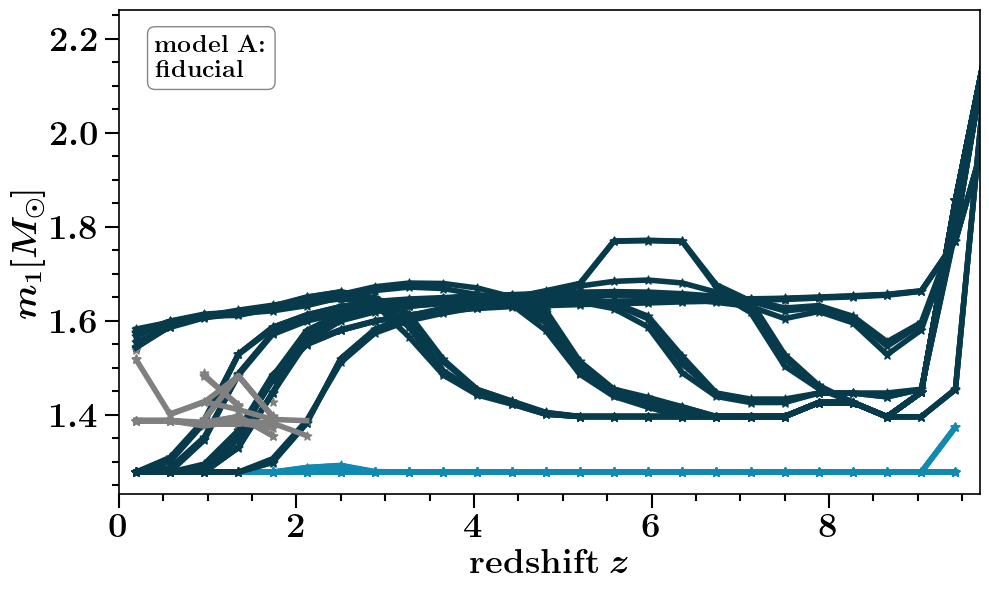


at BPS model  B
at DCOtype = BNS


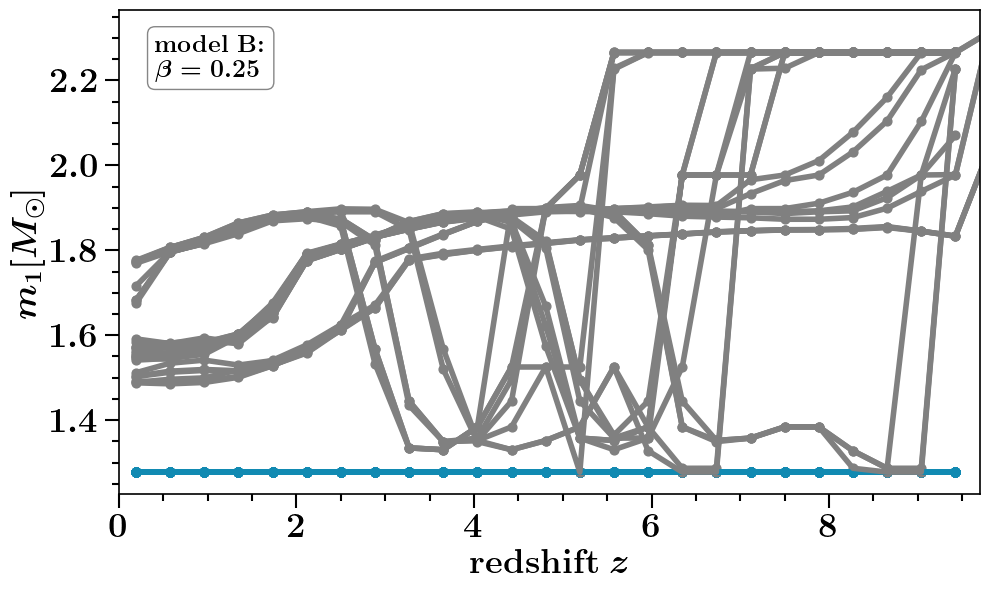


at BPS model  C
at DCOtype = BNS


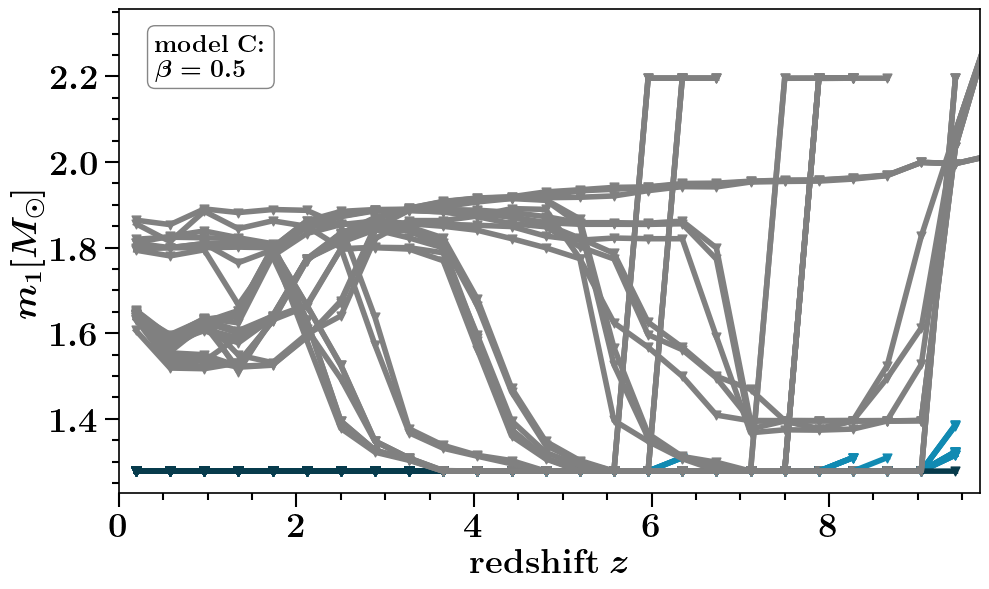


at BPS model  D
at DCOtype = BNS


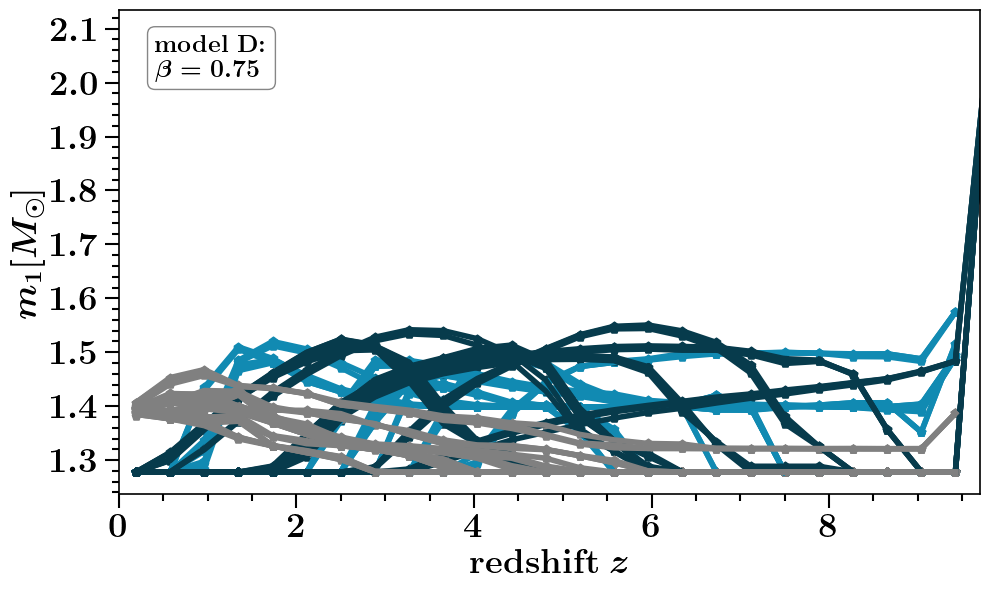


at BPS model  E
at DCOtype = BNS


FileNotFoundError: [Errno 2] No such file or directory: './formation_median/mass_1_LVK_BNS_E_mass_1_LVK_w_merger.csv'

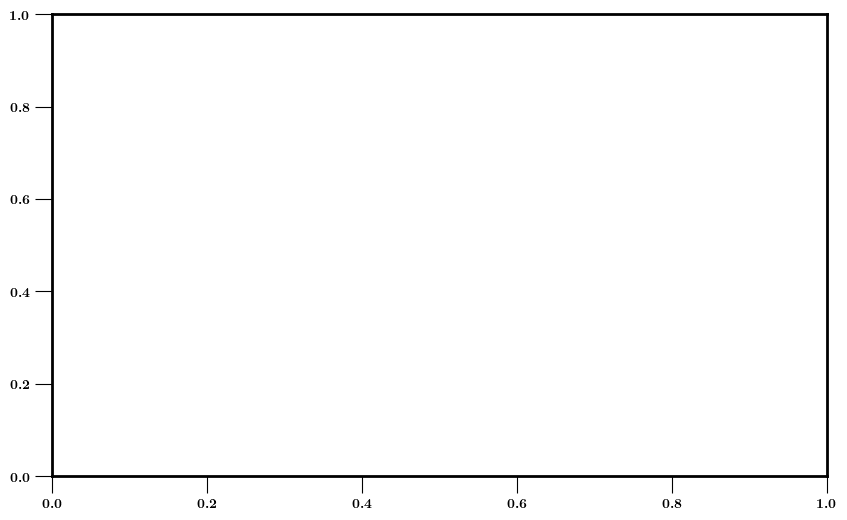

In [12]:




################ CHANGE THE THINGS BELOW ################
quantile_values=[0.5, 0.25, 0.75, 0.1, 0.9 ]
DCOTypeList = ['BNS']#['BHNS', 'BNS', 'BBH'] #, https://arxiv.org/pdf/2402.00935.pdf
pathData='/Volumes/SimonsFoundation/DataDCO/'
single_model=True
dict_channel_list = {'BBH':['classic', 'stable B no CEE'],\
                     'BHNS':['classic', 'stable B no CEE', 'immediate CE'],\
                     'BNS':['classic', r'double-core CE', 'other'] } 
weights_type='merger'# 'formation' #
# create_df_file = True  # create it in seperate function that is provided earlier on. 
BPSmodelName='A'
###########################################################




# for xparam_wanted in [ 'mass_tot', 't_delay', 'mass_ratio_LVK', 'mass_1_LVK', 'mass_2_LVK','chirp_mass_LVK','qZAMS', 'separationInitial''mass_1_LVK', 'mass_2_LVK']:  't_delay', 'mass_ratio_LVK', 'qZAMS', 'chirp_mass_LVK'
for xparam_wanted in ['mass_1_LVK']:  #[ 'mass_tot',  'mass_ratio_LVK', 'qZAMS', 'separationInitial', 't_delay','M1ZAMS', 'M2ZAMS','t_delay']:  #'t_delay', 'mass_ratio_LVK', 'qZAMS',]: # , 'mass_ratio_LVK', 'qZAMS', 'separationInitial', 'M1ZAMS', 'M2ZAMS', 'mass_1_LVK', 'mass_2_LVK']: #, 'M1ZAMS', 'M2ZAMS']:
    print('at xparam ', xparam_wanted)
    
    if single_model==True:enumerate_list = BPSnameslist[:]
    else: enumerate_list = [0]
    for ind_m, BPSmodelName in  enumerate(enumerate_list):
        if single_model==True:
            BPS_models_to_run_list=[BPSmodelName]
            print('at BPS model ', BPSmodelName)
            save_fig_string = BPSmodelName
        else: 
            BPS_models_to_run_list = BPSnameslist
            save_fig_string = 'all'
            
        for DCOtype in DCOTypeList: #'BNS', 'BHNS', 
            print('at DCOtype =', DCOtype)


            ncols, nrows= 1,1
            f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,6), gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})

            ax = plot_xparam_formation_channels_redshift_for_quantiles(axe=ax, DCOtype=DCOtype, BPS_models_to_run_list=BPS_models_to_run_list,\
                                                                  pathData=pathData,  single_model=single_model, quantile_values=quantile_values,\
                                                                               xparam=xparam_wanted, weights_type=weights_type) 


            
            ##  SAVE FIG  ###
            plt.tight_layout()
            plt.subplots_adjust(wspace=0., hspace=0.18)  
            plt.savefig('./formation_median/'+ xparam_wanted + '/zQuantile_' +  DCOtype + '_' + save_fig_string + '_' + xparam_wanted + '_w_' + weights_type + '.png', transparent=False, dpi=300)
            plt.show()
            plt.close()
            print()







## only make plots of existing data 

In [ ]:
print(BPSnameslist)
print(BPSnameslistslistslist)

In [ ]:

################ CHANGE THE THINGS BELOW ################
quantile_values=[0.5] #, 0.25, 0.75, 0.1, 0.9 ]
DCOTypeList = ['BHNS', 'BNS'] #, https://arxiv.org/pdf/2402.00935.pdf
pathData='/Volumes/SimonsFoundation/DataDCO/'
single_model=False # True ; we want all models in one plot :) 
only_channels_with_min_contribution = 0.01 # percent
dict_channel_list = {'BBH':['classic', 'stable B no CEE'],\
                     'BHNS':['classic', 'stable B no CEE', 'immediate CE'],\
                     'BNS':['classic', r'double-core CE', 'other'] } 
weights_type='formation' #'merger'
create_df_file = False ## !! This is important if you only want to run the existing data 
###########################################################




# for xparam_wanted in [ 'mass_tot', 't_delay', 'mass_ratio_LVK', 'mass_1_LVK', 'mass_2_LVK','chirp_mass_LVK','qZAMS', 'separationInitial']:  't_delay', 'mass_ratio_LVK', 'qZAMS', 
for xparam_wanted in [ 't_delay']: # , 'mass_ratio_LVK', 'qZAMS', 'separationInitial', 'M1ZAMS', 'M2ZAMS', 'mass_1_LVK', 'mass_2_LVK']: #, 'M1ZAMS', 'M2ZAMS']:
    print('at xparam ', xparam_wanted)
    
    if single_model==True:enumerate_list = BPSnameslist[:].remove('E')
    else: enumerate_list = [0]
    for ind_m, BPSmodelName in  enumerate(enumerate_list): # I dont want to work with model E anymore 
        if single_model==True:
            BPS_models_to_run_list=[BPSmodelName]
            print('at BPS model ', BPSmodelName)
            save_fig_string = BPSmodelName
        else: 
            BPS_models_to_run_list = BPSnameslist
            print(BPSnameslist)
            BPS_models_to_run_list #.remove('E') # I dont want to work with model E anymore 
            save_fig_string = 'all'
        
        
        for DCOtype in DCOTypeList: #'BNS', 'BHNS', 
            print('at DCOtype =', DCOtype)



            ncols, nrows= 1,1
            f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,6), gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})            

            ax = plot_xparam_formation_channels_redshift_for_quantiles(axe=ax, DCOtype=DCOtype, BPS_models_to_run_list=BPS_models_to_run_list,\
                                                                  pathData=pathData,  single_model=single_model, quantile_values=quantile_values,\
                                                                               xparam=xparam_wanted, weights_type=weights_type, create_df_file=create_df_file) 


            
            ##  SAVE FIG  ###
            plt.tight_layout()
            plt.subplots_adjust(wspace=0., hspace=0.18)  
            plt.savefig('./formation_median/'+ xparam_wanted + '/zQuantile_' +  DCOtype + '_' + save_fig_string + '_' + xparam_wanted + '_w_' + weights_type + '.png', transparent=False, dpi=300)
            plt.show()
            plt.close()
            print()






## ENDS HERE ## 
GO TO other jupyter notebook (in same folder) for the working/most recent version of code as a function of metallicity 

In [ ]:
adsga

# as a function of metallicity 

In [ ]:
def plot_formation_channels_metallicity_xparam(axe='None', DCOtype='BHNS', \
                                          xparam='mass_tot', BPSmodelName='A', 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE'] #, 'vii', 'immediate CE',  r'double-core CE', 'other']
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
#     param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    
    
    massCO_ZAMSM1 = fdata['doubleCompactObjects']['M1'][...].squeeze()
    massCO_ZAMSM2 = fdata['doubleCompactObjects']['M2'][...].squeeze()
    # M1 will be the most massive, M2 the least massive compact object. 
    massCO_LVKM1, massCO_LVKM2 = obtainM1BHandM2BHassymetric(m1=fdata['doubleCompactObjects']['M1'][...].squeeze(), m2=fdata['doubleCompactObjects']['M2'][...].squeeze()) 
    MassRatioCO_LVK = massCO_LVKM2/massCO_LVKM1

    if xparam=='chirp_mass_LVK':
        param_x = chirpmass(massCO_LVKM1, massCO_LVKM2)
        nameX = r'$\mathcal{M}_{\rm{c}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,100,1000)
    elif xparam=='mass_tot':
        param_x = massCO_LVKM1 + massCO_LVKM2
        nameX = r'$\rm{M}_{\rm{tot}} \ [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(1,5,1000)
    elif xparam=='mass_ratio_LVK':
        param_x = MassRatioCO_LVK
        nameX = r'$q$'
        nameY = r'\textbf{PDF}'
        xx = np.linspace(-0.2,1.2,1000)
    elif xparam=='mass_1_LVK':
        param_x = massCO_LVKM1
        nameX = r'$m_1 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-1,50,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
    elif xparam=='mass_2_LVK':
        param_x = massCO_LVKM2
        nameX = r'$m_2 [M_{\odot}]$'
        nameY = r'\textbf{PDF}'
        if DCOtype=='BBH':
            xx = np.linspace(-1,150,1000) # needs to be a little bit larger
        elif DCOtype=='BHNS':
            xx = np.linspace(-2,5,1000)
        elif DCOtype=='BNS':
            xx = np.linspace(-2,5,500)
            
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')
    elif xparam=='log10_t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        param_x = np.log10(param_x)
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)  
        print('obtained params')    
    
    elif xparam=='t_delay':
        param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
        nameX = r'$\log_{10} t_{\rm{delay}} \ [\rm{Gyr}]$'
        nameY = r'\textbf{PDF}'  
        xx = np.linspace(-2.5,2,500)         
    
    

    
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    metallicities = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
    weights_ =  fdata['doubleCompactObjects']['weight'][...].squeeze()
    #     param_x = np.log10(param_x)
    

    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
        
        
        median_at_ZZ = np.zeros_like(np.unique(metallicities))
        
    #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
        for ind_Z, Zvalue in enumerate(np.unique(metallicities)):

            mask_ZZ = metallicities[mask_MRR]==Zvalue

            
            
            if len(weights_[mask_MRR][mask_ZZ])>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE



                if whichQuantity=='median':
                    median_at_ZZ[ind_Z] = weighted_quantile(values=param_x[mask_MRR][mask_ZZ], quantiles=[0.5], sample_weight=weights_[mask_MRR][mask_ZZ])
                    nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                elif whichQuantity=='fraction':
                    mask_systems = param_x[mask_MRR][mask_ZZ] <= value_for_fraction
                    median_at_ZZ[ind_Z] = np.sum(weights_[mask_MRR][mask_ZZ][mask_systems])/np.sum(weights_[mask_MRR][mask_ZZ])
                    nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        
        mask_not_zero = (median_at_ZZ!=0)
        axe.scatter(np.log10(np.unique(metallicities))[mask_not_zero], median_at_ZZ[mask_not_zero], color=c_FC, marker=dictMarkerShape[BPSmodelName])
        axe.plot(np.log10(np.unique(metallicities))[mask_not_zero],    median_at_ZZ[mask_not_zero], color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




    
        




#     ylabel = r'\textbf{Rate}'
        
        
    xlabel = r'\textbf{Metallicity} \ $Z$'
    ylabel = nameX
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
#     axe.set_xlim(0.001,0.3)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)

    if xparam in ['mass_tot']:
        axe.set_ylim(2, 4)        

        
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        if xparam in ['t_delay']:
            axe.set_yscale('log')
            axe.set_ylim(0.001, 2)
    
    
    
#     axe.set_xscale('log')
    
    
    bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
    axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                 xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                zorder=1E10)

    return axe




# plot delay times with fraction 




whichQuantity='median'
xparam = 't_delay'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in ['BNS']:
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_metallicity_xparam(axe=ax, DCOtype=DCOtype, xparam=xparam, BPSmodelName=BPSmodelName,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False) 



        
        
        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.png', transparent=False, dpi=300)
        plt.savefig('./formation_median/'+xparam+'/'+xparam+'_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    



## I am working here :) 

In [ ]:
def plot_formation_channels_metallicity_xparam(axe='None', DCOtype='BHNS', \
                                          BPSmodelName='A', 
                                                  pathData='/Volumes/SimonsFoundation/DataDCO/',\
                                                mask_specific_mssfr=None,\
                                                whichQuantity='median', value_for_fraction=False, \
                                              add_model_label=True):
    """
    whichplot='rate', 'ratio'
    
    """

    pathData='/Volumes/SimonsFoundation/DataDCO/' # path to datafiles 
    redshifts_runs = obtain_redshiftsruns(pathData = pathData) # obtain redshifts that were run     
    adjustedChannelList = ['classic', 'stable B no CEE'] #, 'vii', 'immediate CE',  r'double-core CE', 'other'
    DCOname = DCOname_dict[DCOtype]

    # path for files 
    full_data_path = pathData + alphabetDirDict[BPSmodelName] +'/COMPASCompactOutput_'+ DCOtype +'_' + BPSmodelName + '.h5'

    # read in data 
    fdata = h5.File(full_data_path,'r')
    
    # get the delay time in Gyr 
    param_x = (fdata['doubleCompactObjects']['tform'][...].squeeze() +  fdata['doubleCompactObjects']['tc'][...].squeeze() ) / 1000 # divide by 1000 to make it in [Gyr]
    channels = fdata['doubleCompactObjects']['formaton channel'][...].squeeze()
    metallicities = fdata['doubleCompactObjects']['Metallicity1'][...].squeeze()
    weights_ =  fdata['doubleCompactObjects']['weight'][...].squeeze()
    #     param_x = np.log10(param_x)
    

    
    
    for nrC, Channel in enumerate(adjustedChannelList): 
#         print('now at channel: ', Channel)
        ind_wanted = dictFormationChannelIndex[Channel]
        # set color         
        c_FC = channelColorDict[Channel]
        colors_lighter_FC =  channelColorDict_lighter[Channel]


        mask_MRR = (channels==ind_wanted)
        
        
        
        median_at_ZZ = np.zeros_like(np.unique(metallicities))
        
    #     for ind_mssfr, mssfr in enumerate(MSSFRnameslist[:]):
        for ind_Z, Zvalue in enumerate(np.unique(metallicities)):

            mask_ZZ = metallicities[mask_MRR]==Zvalue

            
            
            if len(weights_[mask_MRR][mask_ZZ])>10:
            ######## EXTRA FLUFF JUST FOR PLOTTING SOME MSSFR, NOT THE BEST CODE



                if whichQuantity=='median':
                    quantiles = weighted_quantile(values=param_x[mask_MRR][mask_ZZ], quantiles=[0.5, 0.25, 0.75], sample_weight=weights_[mask_MRR][mask_ZZ])
                    median_at_ZZ[ind_Z] = quantiles[0] # first requested value is the median
                    nameY = r'$<t_{\rm{delay}}> \ [\rm{Gyr}]$'
                elif whichQuantity=='fraction':
                    mask_systems = param_x[mask_MRR][mask_ZZ] <= value_for_fraction
                    median_at_ZZ[ind_Z] = np.sum(weights_[mask_MRR][mask_ZZ][mask_systems])/np.sum(weights_[mask_MRR][mask_ZZ])
                    nameY = r'$\rm{fraction }  t_{\rm{delay}} < %s \ [\rm{Gyr}]$'%value_for_fraction
                        

        axe.scatter(np.log10(np.unique(metallicities)), median_at_ZZ, color=c_FC, marker=dictMarkerShape[BPSmodelName])
        axe.plot(np.log10(np.unique(metallicities)),    median_at_ZZ, color=c_FC) #, ls=linestyles_mssfrind[ind_mssfr_zind])



        
        
    # always close the dataset
    fdata.close()




    
        




#     ylabel = r'\textbf{Rate}'
        
        
    xlabel = r'\textbf{Metallicity} \ $Z$'
    ylabel = nameY
    
    axe = layoutAxes(axe, nameX=xlabel, nameY=ylabel, setMinor=True)

    
#     axe.set_xlim(0.001,0.3)
    if whichQuantity=='fraction':
        axe.set_ylim(0., 1)
#     else:
#         axe.set_ylim(1, 1E4)
    if whichQuantity=='median':
        axe.set_yscale('log')
    
#     axe.set_xscale('log')
    
    if add_model_label==True:
        bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.95)
        axe.annotate(r'\textbf{model %s:}'%(BPSmodelName) +'\n' + alphabetPhysicalNameDict[BPSmodelName], xy=(0.042, .95),\
                     xycoords='axes fraction', fontsize = fs, weight = 'bold', ha='left', va="top",bbox=bbox_props,\
                    zorder=1E10)

    return axe




In [ ]:
# plot delay times with fraction 




whichQuantity='median'

# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in ['BBH']: #'BNS', 'BHNS', 
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)

        ncols, nrows= 1,1
        f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
                      gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})



        ax = plot_formation_channels_metallicity_xparam(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False, add_model_label=True) 



        
        
        ##  SAVE FIG  ###
        plt.tight_layout()
        plt.subplots_adjust(wspace=0., hspace=0.18)  
        plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.png', transparent=False, dpi=300)
        plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + BPSmodelName + '_' + whichQuantity + '.pdf', transparent=True)
        plt.show()
        plt.close()

                    
                    

## all in one figure 

In [ ]:
whichQuantity='median'
ncols, nrows= 1,1
f, ax= plt.subplots(ncols=ncols,nrows=nrows,figsize=(10,8), 
              gridspec_kw={"width_ratios":1.5*np.ones(ncols), "height_ratios":1*np.ones(nrows)})
# for ind_m, BPSmodelName in  enumerate([BPSnameslist[0]]):
for ind_m, BPSmodelName in  enumerate(BPSnameslist[:]):
#     color_m = colorDirDict[BPSmodelName]
    print('at BPS model ', BPSmodelName)

    for DCOtype in ['BBH']: #'BNS', 'BHNS', 
        print()
        print('at DCOtype =', DCOtype)
    #     for nrC, Channel in enumerate(adjustedChannelList): 
    #     for nrC, Channel in enumerate([adjustedChannelList[0]]): 
    #         print('now at Channel', Channel)





        ax = plot_formation_channels_metallicity_xparam(axe=ax, DCOtype=DCOtype, BPSmodelName=BPSmodelName,\
                                                              pathData=pathData,\
                                                            mask_specific_mssfr=None,\
                                                         whichQuantity=whichQuantity, value_for_fraction=False, add_model_label=False) 



        
        
##  SAVE FIG  ###
plt.tight_layout()
plt.subplots_adjust(wspace=0., hspace=0.18)  
plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + 'combi' + '_' + whichQuantity + '.png', transparent=False, dpi=300)
plt.savefig('./formation_median/delay_time/delay_time_ratesMetallicity_' +  DCOtype + '_' + 'combi' + '_' + whichQuantity + '.pdf', transparent=True)
plt.show()
plt.close()

In [ ]:
Change the above to include and go to zero if metallicity doesnt exist. 